In [1]:
# import 
import numpy as np
import pandas as pd
import os
from math import sqrt
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()

import datetime

In [50]:
class DataSet:
    # クラス変数の定義
    DRIVE_DIR = r'/content/drive/MyDrive/Colab Notebooks/kaggle/H_and_M_Personalized_Fashion_Recommendations'
    INPUT_DIR = os.path.join(DRIVE_DIR, 'input')

    def __init__(self) -> None:
        # インスタンス変数(属性の初期化)
        self.ALL_ITEMS = []
        self.ALL_USERS = []
        self.df_val: pd.DataFrame
        pass

    def read_data(self, c_id_short: bool = True):

        # ファイルパスを用意
        csv_train = os.path.join(DataSet.INPUT_DIR, 'transactions_train.csv')
        csv_sub = os.path.join(DataSet.INPUT_DIR, 'sample_submission.csv')
        csv_users = os.path.join(DataSet.INPUT_DIR, 'customers.csv')
        csv_items = os.path.join(DataSet.INPUT_DIR, 'articles.csv')

        # データをDataFrame型で読み込み
        if c_id_short == True:
            # 実際の購買記録の情報
            self.df = pd.read_parquet(os.path.join(
                DataSet.DRIVE_DIR, 'transactions_train.parquet'))
            # dfのcustomer_idはshort版に加工されてるから、カラム名を変更しておく
            self.df.rename(
                columns={'customer_id': 'customer_id_short'}, inplace=True)

            # dfのarticle_idを文字列に為ておく?
            # 各顧客の情報(メタデータ)
            self.dfu = pd.read_parquet(os.path.join(
                DataSet.DRIVE_DIR, 'customers.parquet'))
            self.dfu.rename(
                columns={'customer_id': 'customer_id_short'}, inplace=True)
            # 各商品の情報(メタデータ)
            self.dfi = pd.read_parquet(os.path.join(
                DataSet.DRIVE_DIR, 'articles.parquet'))
        else:
            self.df = pd.read_csv(csv_train, dtype={'article_id': str},
                                  parse_dates=['t_dat']  # datetime型で読み込み
                                  )
            self.dfu = pd.read_csv(csv_users)  # 各顧客の情報(メタデータ)
            self.dfi = pd.read_csv(
                csv_items, dtype={'article_id': str})  # 各商品の情報(メタデータ)

            # customer_id_shortカラムを生成
            self.df['customer_id_short'] = self.df["customer_id"].apply(lambda s: int(s[-16:], 16)).astype("uint64")
            self.dfu['customer_id_short'] =self.dfu["customer_id"].apply(lambda s: int(s[-16:], 16)).astype("uint64")

        # price カラムを×10^3しておく...その方が、小数点以下と整数で分けやすい??
        self.df['price'] = self.df['price'] * (10 **3)

        # 提出用のサンプル
        self.df_sub = pd.read_csv(csv_sub)
        

        # customer_idカラムのみのpd.DataFrameを作っておく(たぶん色々便利なので)
        self.df_sub["customer_id_short"] = pd.DataFrame(
            self.df_sub["customer_id"].apply(lambda s: int(s[-16:], 16))).astype("uint64")
        self.cid = pd.DataFrame(self.df_sub["customer_id_short"])

    def read_data_sampled(self, sampling_percentage: float = 5):
        # ファイルパスを用意
        sampled_data_dir = os.path.join(DataSet.INPUT_DIR, 'sampling_dir')
        path_transactions = os.path.join(
            sampled_data_dir, f'transactions_train_sample{sampling_percentage}.csv.gz')
        path_article = os.path.join(
            sampled_data_dir, f'articles_train_sample{sampling_percentage}.csv.gz')
        path_customers = os.path.join(
            sampled_data_dir, f'customers_sample{sampling_percentage}.csv.gz')

        # インスタンス変数として読み込み
        self.df = pd.read_csv(path_transactions,
                              dtype={'article_id': str},
                              parse_dates=['t_dat']  # datetime型で読み込み
                              )
        # price カラムを×10^3しておく...その方が、小数点以下と整数で分けやすい??
        self.df['price'] = self.df['price'] * (10 **3)
        self.dfi = pd.read_csv(path_article, dtype={'article_id': str})
        self.dfu = pd.read_csv(path_customers)
        # df_subはそのまま
        csv_sub = os.path.join(DataSet.INPUT_DIR, 'sample_submission.csv')
        self.df_sub = pd.read_csv(csv_sub)
        # customer_id_shortカラムを作る.
        self.df_sub["customer_id_short"] = pd.DataFrame(
            self.df_sub["customer_id"].apply(lambda s: int(s[-16:], 16))).astype("uint64")

        # customer_idカラムのみのpd.DataFrameを作っておく(たぶん色々便利なので)
        self.cid = pd.DataFrame(self.dfu["customer_id_short"].copy())
        print(self.cid)

In [3]:
Colab_bool = False
# Load data
if Colab_bool==False:
    df_t = pd.read_csv(r'C:\Users\Masat\デスクトップ_Instead\webアプリ開発\H_and_M_Personalized_Fashion_Recommendations\input\transactions_train_sample5.csv.gz')
    df_i = pd.read_csv(r'C:\Users\Masat\デスクトップ_Instead\webアプリ開発\H_and_M_Personalized_Fashion_Recommendations\input\articles_train_sample5.csv.gz')
    df_u = pd.read_csv(r'C:\Users\Masat\デスクトップ_Instead\webアプリ開発\H_and_M_Personalized_Fashion_Recommendations\input\customers_sample5.csv.gz')

# 本番環境(=colab)では...
if Colab_bool :
    # DataSetオブジェクトの読み込み
    dataset = DataSet()
    # DataFrameとしてデータ読み込み
    dataset.read_data(c_id_short=True)

    # データをDataFrame型で読み込み
    df_t = dataset.df
    df_sub = dataset.df_sub # 提出用のサンプル
    df_u = dataset.dfu # 各顧客の情報(メタデータ)
    df_i = dataset.dfi # 各商品の情報(メタデータ)

In [4]:
# merge
df_t = pd.merge(
    df_t, df_i, on='article_id', how='left'
)


In [10]:
# datetime型に変換
df_t['t_dat'] = pd.to_datetime(df_t['t_dat'])

In [5]:
df_t.head()

,t_dat,customer_id_short,article_id,price,sales_channel_id,week,product_code,prod_name,product_type_no,product_type_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2018-09-20,52397916724644664,638282001,0.022017,2,0,638282,33213,67,39,...,89,6,6,1,0,65,29,1019,1,41754
1,2018-09-20,52397916724644664,684033003,0.030492,2,0,684033,12397,78,26,...,59,1,1,2,2,52,25,1019,1,20690
2,2018-09-20,52397916724644664,617903013,0.022017,2,0,617903,1855,255,3,...,0,0,0,1,0,8,17,1005,0,2120
3,2018-09-20,52397916724644664,617903009,0.022017,2,0,617903,1855,255,3,...,0,0,0,1,0,8,17,1005,0,2120
4,2018-09-20,52397916724644664,661435002,0.084729,2,0,661435,7894,272,0,...,60,1,1,2,2,57,37,1016,11,3703


In [19]:
# 週毎の売上集計
df_t.groupby(pd.Grouper(key='t_dat', freq="W"))['customer_id_short'].count()
# 月毎の売上集計
df_t.groupby(pd.Grouper(key='t_dat', freq="MS"))['customer_id_short'].count()


t_dat
2018-09-01    29754
2018-10-01    69634
2018-11-01    62438
2018-12-01    57735
2019-01-01    63457
2019-02-01    56607
2019-03-01    65308
2019-04-01    73313
2019-05-01    77657
2019-06-01    97503
2019-07-01    88606
2019-08-01    62694
2019-09-01    61315
2019-10-01    56847
2019-11-01    59173
2019-12-01    54447
2020-01-01    53814
2020-02-01    51148
2020-03-01    51426
2020-04-01    66166
2020-05-01    68881
2020-06-01    88436
2020-07-01    67601
2020-08-01    61898
2020-09-01    39092
Freq: MS, Name: customer_id_short, dtype: int64

In [21]:
df_t.groupby(pd.Grouper(key='t_dat', freq="MS"))['article_id'].unique()

t_dat
2018-09-01    [638282001, 684033003, 617903013, 617903009, 6...
2018-10-01    [689431001, 652869001, 654758001, 671505002, 7...
2018-11-01    [624634003, 673677002, 617080002, 637255001, 6...
2018-12-01    [712407001, 691799002, 379780038, 638887004, 6...
2019-01-01    [707082002, 657512002, 657476012, 568013001, 5...
2019-02-01    [563313005, 692930003, 689109003, 539723005, 5...
2019-03-01    [576897001, 729441001, 700090001, 576897007, 7...
2019-04-01    [721118001, 713158001, 506166047, 568931001, 7...
2019-05-01    [469658019, 702883001, 541518015, 702477003, 6...
2019-06-01    [710695002, 776989001, 731119005, 369796026, 6...
2019-07-01    [707488004, 664319016, 793911001, 351484026, 7...
2019-08-01    [439285009, 775382001, 693322009, 484398001, 7...
2019-09-01    [788067002, 685814022, 720504008, 779979003, 7...
2019-10-01    [736530007, 736531006, 670115001, 581178007, 7...
2019-11-01    [635040002, 533022003, 493103034, 537116001, 7...
2019-12-01    [723173001, 74072300

In [38]:
df_item_sales_timeseries = df_t.groupby(by=['article_id', pd.Grouper(key='t_dat', freq="MS")])['customer_id_short'].count()
df_item_sales_timeseries.head()

article_id  t_dat     
108775015   2018-09-01    25
            2018-10-01    89
            2018-11-01    78
            2018-12-01    68
            2019-01-01    66
Name: customer_id_short, dtype: int64

In [30]:
print(type(df_item_sales_timeseries))
df_item_sales_timeseries.loc[108775015]

df = pd.DataFrame()

<class 'pandas.core.series.Series'>


t_dat
2018-09-01    25
2018-10-01    89
2018-11-01    78
2018-12-01    68
2019-01-01    66
2019-02-01    60
2019-03-01    40
2019-04-01    52
2019-05-01    28
2019-06-01    12
2019-07-01     3
2019-08-01     2
2019-10-01     1
2020-02-01     4
2020-03-01     1
Name: customer_id_short, dtype: int64

In [39]:
# マルチインデックスの内側(今回はt_dat)がunstackingされる！
df_item_sales_timeseries_unstack = df_item_sales_timeseries.unstack(fill_value=0)

In [41]:
df_item_sales_timeseries_unstack

t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,25,89,78,68,66,60,40,52,28,12,...,0,0,4,1,0,0,0,0,0,0
108775044,7,37,27,19,27,49,35,44,62,31,...,0,3,1,4,0,2,2,1,2,0
108775051,3,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110065001,1,5,9,5,3,1,4,2,0,4,...,2,2,0,0,0,0,3,0,1,0
110065002,1,5,0,2,7,3,1,0,1,0,...,1,2,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949198001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
949551001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4
949551002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [46]:
# アイテムidサブカテゴリのカラム
df_i.columns
item_subcategory_columns = [
    # 'article_id',
 'product_code', 'prod_name', 'product_type_name', 'product_group_name', 'graphical_appearance_no',
                            'graphical_appearance_name', 'colour_group_name',
                            'perceived_colour_value_name',
                            'perceived_colour_master_name',
                            'department_name', 'index_name',
                            'index_group_name', 'section_name', 'garment_group_name']


In [47]:
time_series_sales_dict = {}
for target_columns in item_subcategory_columns:
    print(target_columns)
    df_sales_timeseries = df_t.groupby(by=[target_columns, pd.Grouper(key='t_dat', freq="MS")])['customer_id_short'].count()
    # マルチインデックスの内側(今回はt_dat)がunstackingされる！
    df_sales_timeseries = df_sales_timeseries.unstack(fill_value=0)
    display(df_sales_timeseries)
    # dictに保存
    time_series_sales_dict[target_columns] = df_sales_timeseries
    del df_sales_timeseries

product_code


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
product_code,,,,,,,,,,,,,,,,,,,,,
108775,35,131,105,87,93,109,75,96,90,43,...,0,3,5,5,0,2,2,1,2,0
110065,5,17,16,18,17,6,7,2,2,8,...,4,4,0,0,0,3,3,1,1,0
111565,6,19,9,18,27,12,5,3,5,4,...,27,15,19,5,9,3,2,3,2,7
111586,16,37,44,72,27,30,27,25,21,4,...,78,42,29,16,0,3,7,11,5,11
111593,18,48,46,88,24,19,30,17,28,13,...,79,27,36,11,0,1,2,1,7,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947934,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
949198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
949551,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6


prod_name


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
prod_name,,,,,,,,,,,,,,,,,,,,,
0,0,23,10,8,8,23,9,14,26,26,...,3,3,0,6,4,12,20,14,8,2
1,2,7,10,12,16,6,22,31,33,42,...,19,11,4,4,19,32,50,66,31,6
2,7,13,9,11,9,29,13,29,40,39,...,8,10,21,13,32,68,78,65,28,4
3,0,0,0,0,0,0,0,0,5,4,...,103,28,74,43,11,39,100,95,81,54
4,10,40,14,11,16,3,3,0,2,0,...,11,4,0,0,0,1,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45868,0,0,0,2,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
45869,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
45870,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


product_type_name


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
product_type_name,,,,,,,,,,,,,,,,,,,,,
0,4981,11396,9266,8330,10069,9378,10346,9299,8615,8836,...,7078,7348,7578,8395,8735,7801,8954,7737,7476,6636
1,1632,4112,4622,4648,3612,4001,5655,8774,9444,12882,...,5272,4380,4203,4773,8238,9472,13109,8504,7894,2848
2,5544,12293,11602,9385,9194,5289,4842,2126,1946,1633,...,8235,6848,4828,3704,1461,1497,1289,1539,2984,4924
3,1929,4319,3040,2676,3639,4629,5523,7147,6183,7948,...,2198,2822,2976,3652,6243,5558,6788,5971,4789,2190
4,1071,2832,2465,2430,2867,3155,3768,3861,3650,4385,...,2323,2588,3005,3059,2839,2985,4372,3521,3034,2555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
127,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
128,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


product_group_name


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
product_group_name,,,,,,,,,,,,,,,,,,,,,
0,14781,34407,29733,25743,28052,23842,27353,26459,25497,31066,...,22802,22371,20613,20419,22025,20729,26729,22911,22449,18466
1,6931,15975,13050,11917,13959,13313,14911,16695,17184,21966,...,10821,11364,11235,11969,15854,15183,19854,14678,13399,9204
2,1819,4551,4981,5107,4039,4512,6201,9662,10527,14653,...,5720,4812,4673,5171,8904,10053,14090,9165,8574,3094
3,1617,3717,4161,4104,3433,3233,2965,3066,3330,3625,...,4312,3111,2986,2289,2010,2668,3418,3551,3233,1896
4,1947,4604,4905,4927,5744,4753,4577,4873,5708,6512,...,5154,5838,4783,4979,5885,5951,6896,5959,5191,3074
5,772,1709,1403,1283,1368,1249,1709,2235,2146,2802,...,1291,1007,825,1004,1734,1445,2139,1584,1152,642
6,583,1823,976,1264,4339,3808,5745,8473,11272,15018,...,872,2987,3891,3591,8136,11297,12884,7050,5596,579
7,923,1975,2088,2329,1402,1248,1257,1144,1312,1056,...,2105,1425,1397,947,666,894,1310,1360,1162,1053
8,353,811,1097,988,1010,585,456,578,591,654,...,1179,701,533,793,634,393,601,603,396,490


graphical_appearance_no


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
graphical_appearance_no,,,,,,,,,,,,,,,,,,,,,
-1,8,26,28,23,79,44,48,35,42,45,...,1,5,0,1,2,0,2,0,0,0
1010001,2262,5857,5123,5245,6908,7055,8916,12557,14281,19994,...,5232,5824,5701,5359,7551,9045,12639,8328,6965,2503
1010002,111,465,703,543,574,297,229,153,141,154,...,532,255,156,116,87,96,141,139,137,85
1010003,2,5,3,4,3,1,2,1,2,2,...,6,1,1,1,0,0,2,0,0,2
1010004,880,1889,1501,1430,1176,967,962,595,428,576,...,2008,1518,1180,877,593,596,872,918,1082,1091
1010005,527,1004,858,611,997,663,622,474,491,550,...,361,390,307,272,221,180,223,275,151,165
1010006,106,304,273,392,462,315,498,626,597,1218,...,289,381,364,495,870,581,919,584,475,219
1010007,158,480,330,352,409,363,470,583,597,803,...,367,587,629,771,770,799,1131,1130,1040,446
1010008,562,1356,907,945,967,757,601,786,752,1024,...,512,484,463,423,439,422,617,506,306,177


graphical_appearance_name


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
graphical_appearance_name,,,,,,,,,,,,,,,,,,,,,
0,15761,37586,33869,30842,33580,29738,35337,38823,40948,50036,...,30874,31235,30242,31315,39842,40146,51703,40953,38026,24552
1,2262,5857,5123,5245,6908,7055,8916,12557,14281,19994,...,5232,5824,5701,5359,7551,9045,12639,8328,6965,2503
2,3261,6775,6297,4857,5072,3229,2878,2480,2418,2527,...,4826,4383,3069,2609,2296,2262,2561,2252,3194,3243
3,1424,2999,2191,1932,2877,3258,4755,5435,5312,7304,...,1022,1301,1479,1640,2772,2842,4027,2665,2184,724
4,1931,4187,3112,2816,4060,4480,4521,4279,4182,5473,...,2670,2945,3406,3713,5465,4894,5670,4278,3985,3166
5,562,1356,907,945,967,757,601,786,752,1024,...,512,484,463,423,439,422,617,506,306,177
6,713,1312,1077,918,1160,1195,1293,1353,1147,1504,...,513,566,559,653,542,536,730,823,752,524
7,880,1889,1501,1430,1176,967,962,595,428,576,...,2008,1518,1180,877,593,596,872,918,1082,1091
8,527,1004,858,611,997,663,622,474,491,550,...,361,390,307,272,221,180,223,275,151,165


colour_group_name


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
colour_group_name,,,,,,,,,,,,,,,,,,,,,
0,10625,26258,26069,24116,23727,19364,21682,22435,24138,30234,...,22536,21339,19346,17597,20892,20692,25649,20654,20922,14507
1,2824,6578,5401,4947,5803,5041,5754,6104,6211,7923,...,3109,2794,2371,2479,3154,3221,4365,3239,2777,1564
2,2269,5456,4018,4097,5152,5729,7794,10173,10514,13756,...,3510,3927,4343,5155,8720,9449,12845,9521,7661,3185
3,929,1839,1359,1483,1939,1566,1809,1786,1782,2362,...,1091,1401,1601,1595,2022,2225,3075,2610,2034,933
4,1412,3026,2858,2579,2584,1752,1402,1279,1140,1429,...,1683,1640,1214,1163,1274,1042,1211,1077,1489,1475
5,636,1590,1367,1375,1753,1789,2180,2881,3169,4739,...,2139,1973,1907,2295,2949,3263,4844,3255,3102,1995
6,1094,2182,1641,1319,2048,2477,2961,2856,2715,3213,...,1199,1262,1648,1872,3163,2891,3621,2650,2350,1589
7,631,1448,1943,2084,1807,1644,2417,2688,2914,3157,...,1379,1020,986,1196,1422,1843,1726,822,448,212
8,888,1818,1256,1316,1641,1933,2317,2744,2697,3494,...,611,1063,1423,1653,2525,2492,3165,2440,2050,724


perceived_colour_value_name


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
perceived_colour_value_name,,,,,,,,,,,,,,,,,,,,,
0,16253,39410,37405,33655,34351,28645,31320,32677,35181,44142,...,31578,28890,25232,22775,27142,27228,34338,27181,27066,18776
1,4594,9490,8349,8078,9750,8769,10400,12598,12889,16361,...,8221,9117,9423,10609,12729,12799,17947,13886,12439,8484
2,3309,7719,5617,5958,7018,7852,9970,12951,13573,17630,...,4646,5398,6231,7489,12114,14255,18069,13507,10815,4406
3,3276,7734,5938,5238,7633,6902,7571,7944,8456,11026,...,5755,6723,6384,6872,9325,8909,10760,7744,7738,5826
4,931,2266,2071,1945,1874,1866,2674,3600,3896,4292,...,1727,1456,1779,1881,2904,3701,4484,3178,2286,972
5,1318,2864,2970,2796,2731,2512,3291,3434,3527,3918,...,2514,2216,2099,1796,1936,1976,2808,2083,1519,609
6,70,133,77,61,53,34,48,86,106,105,...,6,9,0,3,15,13,28,22,35,19
7,3,18,11,4,47,27,34,23,29,29,...,0,5,0,1,1,0,2,0,0,0


perceived_colour_master_name


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
perceived_colour_master_name,,,,,,,,,,,,,,,,,,,,,
0,10493,26059,25770,23848,23440,19189,21538,22177,23671,29654,...,22237,21611,19601,17663,20988,20750,25695,20702,21100,14513
1,4810,10554,8255,7537,9479,9427,11045,11780,11704,14711,...,4960,5118,5426,6022,8917,8620,11211,8322,7246,3907
2,2824,6579,4962,5055,6190,6804,9169,12201,13469,17965,...,4709,5131,5727,6562,10347,11102,15129,11253,9597,4836
3,1675,3149,2346,2401,3343,2770,3077,3047,3054,4063,...,2019,3101,3254,3355,4220,4526,5490,4526,3768,1853
4,3059,6627,6351,5614,5810,3927,3411,3484,3111,3679,...,3920,3508,2628,2452,2630,2308,2949,2707,3298,3298
5,1857,4635,4957,4437,3625,2740,3611,3930,4089,4751,...,3805,2494,1920,1833,1993,2420,2631,1447,958,588
6,1074,2532,2163,2134,3557,3408,3619,4476,4989,5856,...,3688,4185,3961,4112,4732,5136,7408,5158,4706,3228
7,792,1666,1600,1277,1762,1514,1856,2115,2018,2079,...,1700,1461,1811,1654,2802,3118,3444,2175,1563,954
8,697,1708,1082,881,1154,1762,2228,2520,2578,3320,...,989,1496,1747,1897,2571,2511,3206,2109,1779,938


department_name


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
department_name,,,,,,,,,,,,,,,,,,,,,
0,958,2773,2417,2268,2462,2587,3554,4410,4334,4895,...,2041,2179,2035,2854,4130,3947,5603,3898,3304,1508
1,2324,6001,6248,4863,4651,2752,2389,1093,1150,904,...,5516,3890,2367,1663,850,874,823,667,2253,3821
2,1819,4369,3613,3183,3368,3307,4194,4077,4086,4477,...,3454,2798,2957,2905,3683,3702,4893,3634,3052,2444
3,1384,3194,2682,2592,2462,2542,3775,4081,4305,5915,...,2436,2512,2583,2667,3472,3312,4954,3572,3174,2189
4,416,1025,1246,1283,870,1113,1705,3099,3687,4754,...,2162,1622,1616,1747,2879,3456,4351,2840,2889,839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,5,1,1,2,9,7
246,0,7,3,10,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0


index_name


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
index_name,,,,,,,,,,,,,,,,,,,,,
0,11921,28427,25568,22151,23790,21780,27419,31008,31948,39517,...,23373,21145,20107,21065,27352,27982,37153,26506,25338,17976
1,7029,16643,13851,12591,14796,13116,15582,15621,15647,21204,...,10745,12322,11989,13067,15255,13305,17022,14320,13658,9185
2,1845,4251,4295,4628,2774,2640,2700,3541,3871,4728,...,4319,2588,2464,1919,2977,3685,5063,4074,3446,2278
3,1319,2263,1787,1794,1605,1326,476,534,407,493,...,502,340,213,227,252,216,283,281,254,245
4,1390,3104,2225,1952,1772,1691,1184,1337,918,1297,...,559,500,451,365,459,390,399,398,406,264
5,483,1088,1045,891,795,849,572,492,311,387,...,370,367,359,250,275,212,373,386,424,299
6,1448,3305,3212,3374,3100,3201,3667,4387,4567,5380,...,4118,2823,2936,2532,3008,3411,4728,4368,3689,2090
7,3095,7601,7495,8235,11139,9095,10823,13729,17244,21365,...,8533,10174,9835,9339,14186,17466,20600,14072,11365,4545
8,241,632,642,450,374,383,238,247,202,260,...,156,121,107,105,122,121,119,103,97,43


index_group_name


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
index_group_name,,,,,,,,,,,,,,,,,,,,,
0,16464,39333,36275,33760,38029,34076,41909,49124,53759,66262,...,36024,34142,32878,32936,44546,48859,62481,44946,40392,24611
1,3433,7087,5699,5087,4546,4249,2470,2610,1838,2437,...,1587,1328,1130,947,1108,939,1174,1168,1181,851
2,7029,16643,13851,12591,14796,13116,15582,15621,15647,21204,...,10745,12322,11989,13067,15255,13305,17022,14320,13658,9185
3,1845,4251,4295,4628,2774,2640,2700,3541,3871,4728,...,4319,2588,2464,1919,2977,3685,5063,4074,3446,2278
4,983,2320,2318,1669,3312,2526,2647,2417,2542,2872,...,1772,3434,2687,2557,2280,2093,2696,3093,3221,2167


section_name


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
section_name,,,,,,,,,,,,,,,,,,,,,
0,5338,11914,11521,10089,10176,9136,11339,13513,15117,19935,...,12266,9977,8476,8045,10999,12639,16720,11552,11224,7850
1,3693,8879,7849,7132,7569,6609,8119,8678,8969,12225,...,5523,6414,6537,6668,7398,6509,8982,7658,7124,4671
2,247,530,546,434,435,459,316,301,195,196,...,209,213,216,163,197,101,190,209,256,192
3,429,782,673,760,602,518,146,177,153,209,...,221,121,88,81,99,77,122,154,99,76
4,591,1255,872,825,804,835,508,602,409,513,...,199,161,166,136,160,135,150,122,141,74
5,1567,3679,3961,4040,4802,3901,3849,4125,4914,5626,...,4525,4980,4145,4248,5125,5314,6508,5680,4659,2632
6,422,843,644,450,431,421,218,259,207,298,...,110,92,79,98,114,70,65,102,100,78
7,1999,4588,3816,3404,3298,3487,4904,4770,4444,5062,...,3756,3610,3913,3659,3761,4112,6649,4830,4545,3174
8,484,754,568,647,563,415,198,196,171,156,...,189,105,60,65,92,86,101,73,82,82


garment_group_name


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
garment_group_name,,,,,,,,,,,,,,,,,,,,,
0,4662,11156,9647,8865,10680,10024,11749,13227,12964,16222,...,7287,8948,8197,9180,10857,10732,14804,12428,10377,5869
1,1655,3805,4187,4140,3487,3383,3075,3133,3501,3747,...,4385,3213,3118,2371,2066,2748,3509,3710,3427,2015
2,3277,6766,5488,4266,5637,5677,5851,7613,7206,9758,...,4315,5257,5142,5877,8876,7971,9430,7838,7242,4750
3,4060,9897,9712,7800,7495,4128,3604,1952,1939,1792,...,7392,5457,3475,2554,1402,1460,1503,1342,3314,5049
4,2288,5398,5803,5901,6713,5364,5253,5470,6293,7003,...,6455,6470,5519,6045,6589,6385,7760,6854,6022,4218
5,3021,7225,5920,5392,6257,6051,7295,7103,6809,7250,...,4988,5055,5184,5448,6392,5988,7504,5880,5363,4284
6,1997,4911,4129,3882,3912,4066,6147,6469,6550,8762,...,3366,3798,4337,4296,5175,5109,7650,5764,4963,3118
7,746,1661,1355,1200,1314,1220,1690,2221,2141,2796,...,1225,966,804,978,1705,1430,2115,1539,1115,629
8,1123,2867,3203,3089,2185,2443,3682,5952,6951,10166,...,3516,2861,2975,3276,4883,5515,7402,5011,5026,1621


In [51]:
time_series_sales_dict.keys()

dict_keys(['product_code', 'prod_name', 'product_type_name', 'product_group_name', 'graphical_appearance_no', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name'])

# 試しに可視化してみる？？

全部のサブカテゴリ特徴量でラグ特徴量とかを作るとカラムが多すぎるかもしれないから...

<AxesSubplot:xlabel='t_dat'>

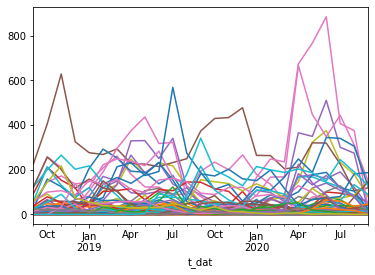

In [70]:
import matplotlib.pyplot as plt

df_sample[:100].T.plot(legend=False)

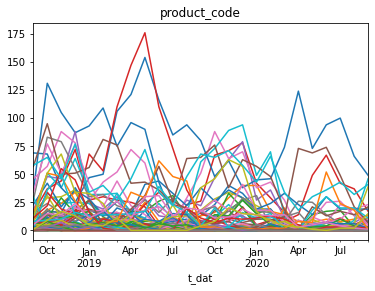

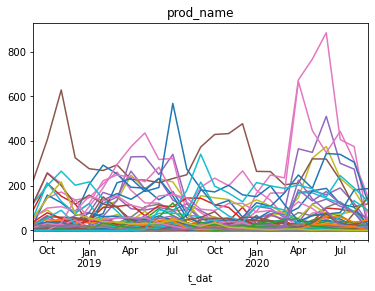

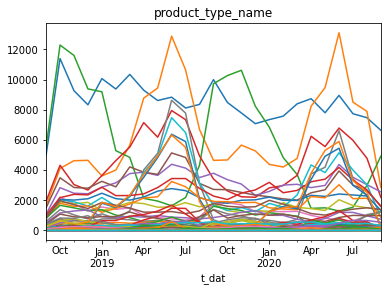

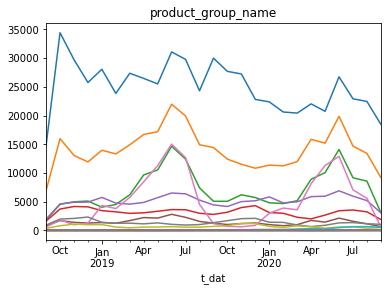

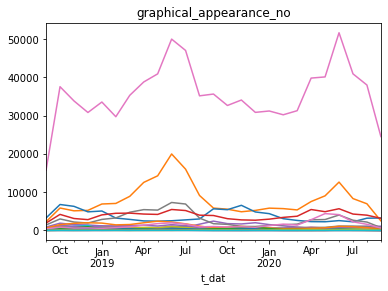

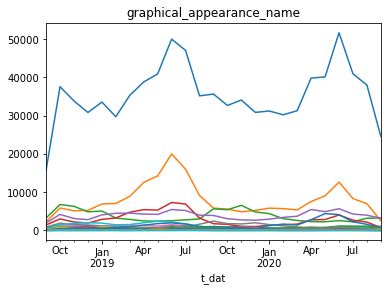

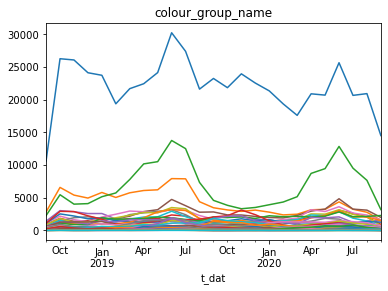

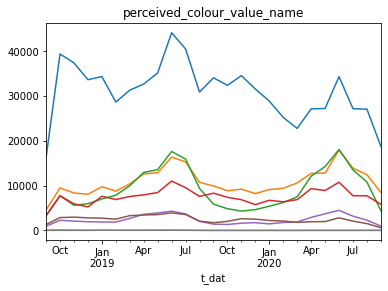

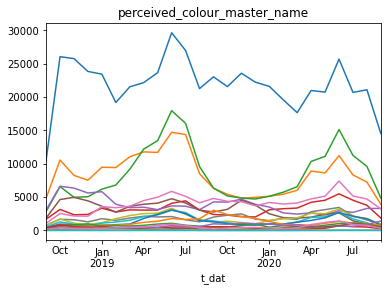

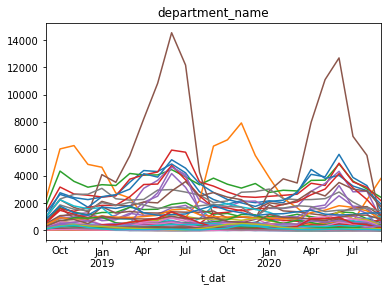

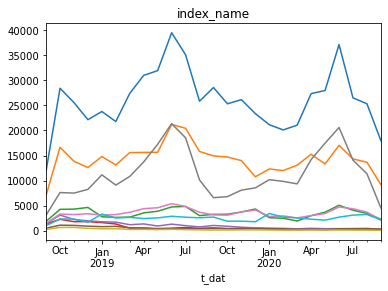

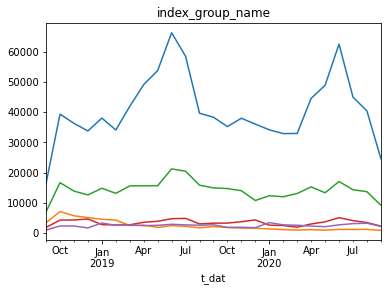

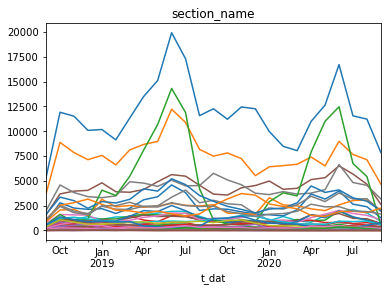

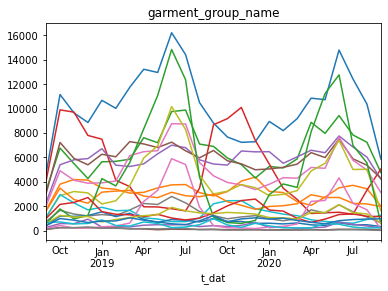

In [72]:
for key in time_series_sales_dict.keys():
    df_sample = time_series_sales_dict[key]
    df_sample[:100].T.plot(legend=False)
    plt.title(key)

# ラグ特徴量を作りたい

例えば、t期の気温を予測したい場合、前日すなわちt-1期の気温を特徴量として使用したり、前々日すなわちt-2期の気温を特徴量として使用することがあります。t-1期の気温やt-2期の気温をラグ特徴量と言います。

In [55]:
# ラグ特徴量を作りたい
df_sample = time_series_sales_dict['prod_name']
display(df_sample.head())
display(df_sample.shift(1, axis=1).head())
display(df_sample.shift(2, axis=1).head())


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
prod_name,,,,,,,,,,,,,,,,,,,,,
0,0,23,10,8,8,23,9,14,26,26,...,3,3,0,6,4,12,20,14,8,2
1,2,7,10,12,16,6,22,31,33,42,...,19,11,4,4,19,32,50,66,31,6
2,7,13,9,11,9,29,13,29,40,39,...,8,10,21,13,32,68,78,65,28,4
3,0,0,0,0,0,0,0,0,5,4,...,103,28,74,43,11,39,100,95,81,54
4,10,40,14,11,16,3,3,0,2,0,...,11,4,0,0,0,1,0,1,0,3


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
prod_name,,,,,,,,,,,,,,,,,,,,,
0,NaN,0,23,10,8,8,23,9,14,26,...,1,3,3,0,6,4,12,20,14,8
1,NaN,2,7,10,12,16,6,22,31,33,...,1,19,11,4,4,19,32,50,66,31
2,NaN,7,13,9,11,9,29,13,29,40,...,3,8,10,21,13,32,68,78,65,28
3,NaN,0,0,0,0,0,0,0,0,5,...,42,103,28,74,43,11,39,100,95,81
4,NaN,10,40,14,11,16,3,3,0,2,...,6,11,4,0,0,0,1,0,1,0


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
prod_name,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,0,23,10,8,8,23,9,14,...,3,1,3,3,0,6,4,12,20,14
1,NaN,NaN,2,7,10,12,16,6,22,31,...,2,1,19,11,4,4,19,32,50,66
2,NaN,NaN,7,13,9,11,9,29,13,29,...,0,3,8,10,21,13,32,68,78,65
3,NaN,NaN,0,0,0,0,0,0,0,0,...,13,42,103,28,74,43,11,39,100,95
4,NaN,NaN,10,40,14,11,16,3,3,0,...,4,6,11,4,0,0,0,1,0,1


# ローリング特徴量を作りたい

ローリング特徴量とは、過去の一定期間（Rolling Window）の集計値を特徴量（説明変数）としたものです。

rolling()関数でローリング特徴量を作ることができます。例えば、過去3期を対象とする場合、rolling(3)とします。

In [57]:
# 過去三期平均(当期含む)のローリング特徴量を作ってみる。
df_sample.rolling(window=3, axis=1).mean()


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
prod_name,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,11.000000,13.666667,8.666667,13.000000,13.333333,15.333333,16.333333,22.000000,...,2.333333,2.333333,2.000000,3.000000,3.333333,7.333333,12.000000,15.333333,14.000000,8.000000
1,NaN,NaN,6.333333,9.666667,12.666667,11.333333,14.666667,19.666667,28.666667,35.333333,...,7.333333,10.333333,11.333333,6.333333,9.000000,18.333333,33.666667,49.333333,49.000000,34.333333
2,NaN,NaN,9.666667,11.000000,9.666667,16.333333,17.000000,23.666667,27.333333,36.000000,...,3.666667,7.000000,13.000000,14.666667,22.000000,37.666667,59.333333,70.333333,57.000000,32.333333
3,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667,3.000000,...,52.666667,57.666667,68.333333,48.333333,42.666667,31.000000,50.000000,78.000000,92.000000,76.666667
4,NaN,NaN,21.333333,21.666667,13.666667,10.000000,7.333333,2.000000,1.666667,0.666667,...,7.000000,7.000000,5.000000,1.333333,0.000000,0.333333,0.333333,0.666667,0.333333,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45868,NaN,NaN,0.000000,0.666667,1.000000,1.000000,0.333333,0.000000,0.000000,0.000000,...,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
45869,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.333333,0.333333,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
45870,NaN,NaN,0.000000,0.000000,0.000000,0.666667,0.666667,0.666667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [58]:
# 過去三期平均(前期まで)のローリング特徴量を作ってみる。
df_sample.shift(1, axis=1).rolling(window=3, axis=1).mean()


t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
prod_name,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,11.000000,13.666667,8.666667,13.000000,13.333333,15.333333,16.333333,...,2.000000,2.333333,2.333333,2.000000,3.000000,3.333333,7.333333,12.000000,15.333333,14.000000
1,NaN,NaN,NaN,6.333333,9.666667,12.666667,11.333333,14.666667,19.666667,28.666667,...,2.333333,7.333333,10.333333,11.333333,6.333333,9.000000,18.333333,33.666667,49.333333,49.000000
2,NaN,NaN,NaN,9.666667,11.000000,9.666667,16.333333,17.000000,23.666667,27.333333,...,3.333333,3.666667,7.000000,13.000000,14.666667,22.000000,37.666667,59.333333,70.333333,57.000000
3,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667,...,27.333333,52.666667,57.666667,68.333333,48.333333,42.666667,31.000000,50.000000,78.000000,92.000000
4,NaN,NaN,NaN,21.333333,21.666667,13.666667,10.000000,7.333333,2.000000,1.666667,...,4.666667,7.000000,7.000000,5.000000,1.333333,0.000000,0.333333,0.333333,0.666667,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45868,NaN,NaN,NaN,0.000000,0.666667,1.000000,1.000000,0.333333,0.000000,0.000000,...,0.000000,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
45869,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.333333,1.333333,0.333333,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000
45870,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.666667,0.666667,0.666667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# エクスパンディング特徴量

エクスパンディング特徴量とは、過去すべての期間（Expanding Window）の集計値を特徴量（説明変数）としたものです。

expanding()関数でローリング特徴量を作ることができます。

In [65]:
df_sample.expanding(axis=1).mean()

t_dat,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,...,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01
prod_name,,,,,,,,,,,,,,,,,,,,,
0,0.0,11.5,11.000000,10.25,9.8,12.000000,11.571429,11.875,13.444444,14.7,...,13.7500,13.117647,12.388889,12.052632,11.65,11.666667,12.045455,12.130435,11.958333,11.56
1,2.0,4.5,6.333333,7.75,9.4,8.833333,10.714286,13.250,15.444444,18.1,...,18.6250,18.176471,17.388889,16.684211,16.80,17.523810,19.000000,21.043478,21.458333,20.84
2,7.0,10.0,9.666667,10.00,9.8,13.000000,13.000000,15.000,17.777778,19.9,...,17.6875,17.235294,17.444444,17.210526,17.95,20.333333,22.954545,24.782609,24.916667,24.08
3,0.0,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000,0.555556,0.9,...,13.5000,14.352941,17.666667,19.000000,18.60,19.571429,23.227273,26.347826,28.625000,29.64
4,10.0,25.0,21.333333,18.75,18.2,15.666667,13.857143,12.125,11.000000,9.9,...,7.8750,7.647059,7.222222,6.842105,6.50,6.238095,5.954545,5.739130,5.500000,5.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45868,0.0,0.0,0.000000,0.50,0.6,0.500000,0.428571,0.375,0.333333,0.3,...,0.1875,0.235294,0.222222,0.210526,0.20,0.190476,0.181818,0.173913,0.166667,0.16
45869,0.0,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000,0.000000,0.0,...,0.3125,0.294118,0.333333,0.315789,0.30,0.285714,0.272727,0.260870,0.250000,0.24
45870,0.0,0.0,0.000000,0.00,0.0,0.333333,0.285714,0.250,0.222222,0.2,...,0.1250,0.117647,0.111111,0.105263,0.10,0.095238,0.090909,0.086957,0.083333,0.08


# 実際に訓練データに結合する時は...

再びstackして、reset_index()して、pd.mergeでサブカテゴリカラム＋t_datで結合する？？
参考
- https://deepage.net/features/pandas-stack-unstack.html

In [64]:
df_sample.stack().reset_index().rename(columns={0:'count'})

,prod_name,t_dat,count
0,0,2018-09-01,0
1,0,2018-10-01,23
2,0,2018-11-01,10
3,0,2018-12-01,8
4,0,2019-01-01,8
...,...,...,...
890695,45873,2020-05-01,0
890696,45873,2020-06-01,0
890697,45873,2020-07-01,0
890698,45873,2020-08-01,0
